# Series de tiempo

Vamos a analizar las series de tiempo las variables de huella de carbono *CO2_tCO2* y el uso de potencia electrica *Usage_kWh*. Esta herramienta es util para captar la evolucion, estacionalidad y tendencias a largo plazo.

En este caso, por ejemplo se muestra picos de contanimacion y consumo electrico. Motivando la toma de decisiones para regular ambos parametros, mejorando el rendimiento de la indstria y reducir el consumo.

## 1. Impotar paquetes

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 2. Carga de los datos

In [14]:
ruta = 'C:/Users/matia/OneDrive/Escritorio/Energy_consumption'

In [15]:
datos = 'trabajo_resultado_calidad.pickle'

In [16]:
ruta_completa = ruta + '/02_Datos/03_Trabajo/' + datos
df = pd.read_pickle(ruta_completa)

Fijar la fecha como indice principal y ordenar cronologicamente la informacion. Tambien recuperamos la frecuencia entre cada registro.

In [17]:
df.set_index('date', inplace = True)

In [18]:
df = df.sort_index()
print(df.index.inferred_freq)

15min


## 3. Visualizacion de la serie temporal del CO2

La grafica muestra la huella de carbono a lo largo del tiempo.

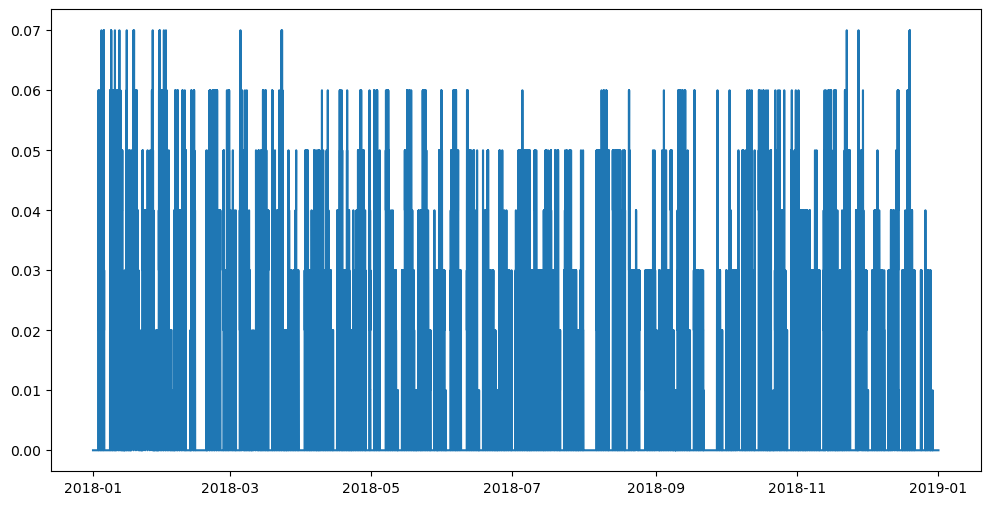

In [19]:
plt.figure(figsize= (12, 6))
plt.plot(df['CO2_tCO2'], label = 'Huella de Carbono(tCO2)')
plt.show()

Los picos de emision son frecuentes en los primeros meses del año 2018, secundado por picos de contaminacion a finales de 2018 e inicios de 2019. 
 
Otro punto a destacar es que durante el transcurso del año la emision fue menor.

### 3.1 Serie diferenciada

Agregando el grafico de la serie diferencianda, que se carecteriza por calcular la diferencia entre valores consecutivos. 

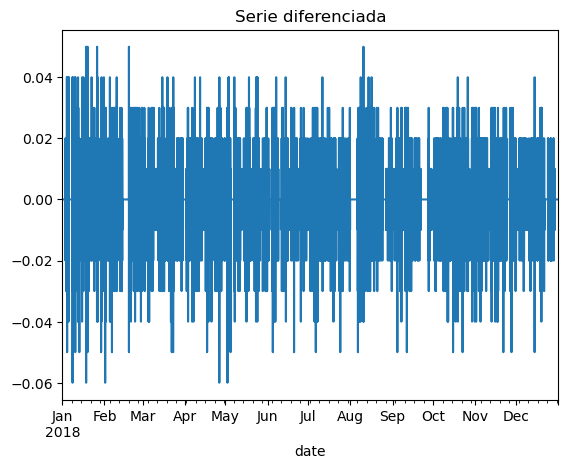

In [8]:
df['CO2_diff'] = df['CO2_tCO2'].diff()
df['CO2_diff'].plot(title='Serie diferenciada')
plt.show()

### 3.2 Descomposicion estacional

Permite descomponer la serie en 3 partes:

1.- Tendencia: cambios a largo plazo.

2.- Estationalidad: patrones repetitivos.

3.- Residuos: el ruido que queda luego de extraer la tendencia y estacionalidad

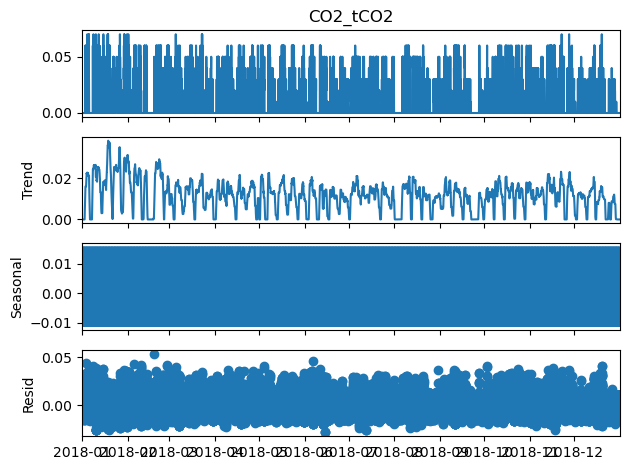

In [9]:
decomposition = seasonal_decompose(df['CO2_tCO2'], model = 'additive', period = 96)
decomposition.plot()
plt.show()

**Comentarios:**

1.- La tendencia muestra que el inicio la emision es mayor.

2.- Por parte de la estacionalidad no considero que se puede deducir nada, dado que no hay un patron relevante.

3.- Respecto a los residuos, dado que no hay una distribucion especifica y los valores de reparten de forma aleatoria alrededor del 0.

## 4. Modelizacion CO2_tCO2

### 4.1 Separacion de dataset

In [8]:
train = df['CO2_tCO2'][:int(0.8 * len(df))]
test = df['CO2_tCO2'][int(0.8 * len(df)):]

### 4.2 Instanciar y aplicar el modelo

In [13]:
model = ARIMA(train, order=(5, 1, 2)) 
model_fit = model.fit()

C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


### 4.3 Predicciones

In [15]:
forecast = model_fit.forecast(steps=len(test))
forecast

2018-10-20 00:00:00    0.030999
2018-10-20 00:15:00    0.031507
2018-10-20 00:30:00    0.030237
2018-10-20 00:45:00    0.029673
2018-10-20 01:00:00    0.029305
                         ...   
2018-12-31 22:45:00    0.029447
2018-12-31 23:00:00    0.029447
2018-12-31 23:15:00    0.029447
2018-12-31 23:30:00    0.029447
2018-12-31 23:45:00    0.029447
Freq: 15min, Name: predicted_mean, Length: 7008, dtype: float64

#### 4.3.1 Grafico con los resultados

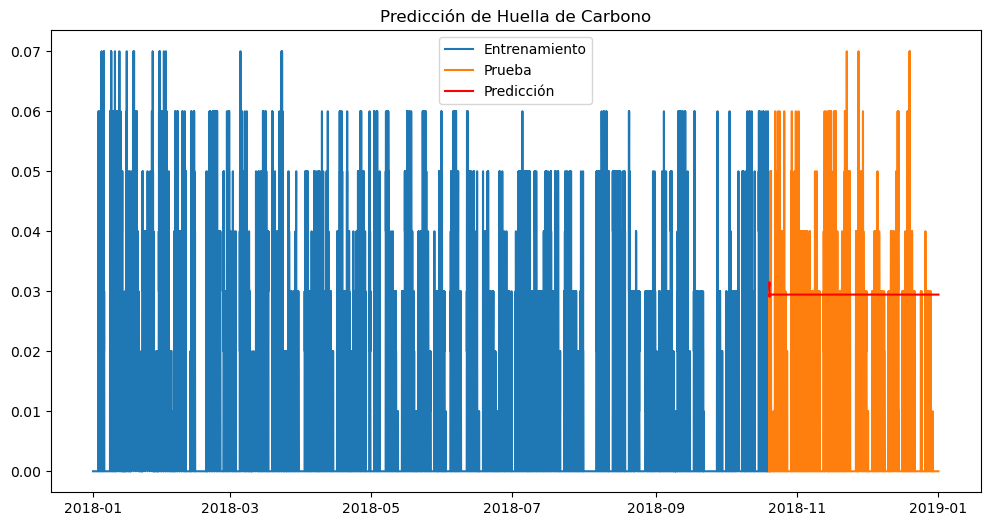

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')  # Datos de entrenamiento
plt.plot(test, label='Prueba')         # Datos reales de prueba
plt.plot(test.index, forecast, label='Predicción', color='red')  # Predicciones
plt.legend()
plt.title('Predicción de Huella de Carbono')
plt.show()

El modelo parece funcionar bien. Hay picos en los inicios de año, que es algo esperado dado el historico de la data. Sin embargo, con los resultados de las predicciones y el grafico me hace pensar que el modelo no esta bien ajustado para generar un mejor resultado.

Voy a aplicar la metrica MAE, para cuantificar el desempeño del modelo.

#### 4.3.2 MAE

In [19]:
mae = mean_absolute_error(test, forecast)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.021680404051497782


## 5. Que tipo de serie es?

Asumiendo como hipotesis incial que la serie no es estacionaria con la prueba estadisitica *adfuller*.

In [36]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train)
print("Estadístico de prueba:", result[0])
print("Valor p:", result[1])

if result[1] > 0.05:
    print("La serie no es estacionaria.")
else:
    print("La serie es estacionaria.")

Estadístico de prueba: -22.641445443217005
Valor p: 0.0
La serie es estacionaria.


## 6. Graficas ACF y PACF

Estas graficas permiten identificar los parametros del modelo ARIMA. 

ACF mide la correlacion entre una serie de tiempo y sus lags, respondiendo la pregunta de en que medida un valor actual esta relacionado con sus valores pasados. En el eje x se grafican los lags, mientras que en el y la magnitud de la correlacion en el rango de -1 a 1. El valor donde las lineas pasan el intervalo de confianza, indican el valor de *q* de ARIMA.

PACF mide la correlacion directa entre un registro y sus lags, eliminado los efectos de los lags intermedios. En el eje y esta la magnitud de correlacion parcial. El punto de corte, que indica el valor del parametro *p* de ARIMA, se determina donde termina la correlacion significativa.

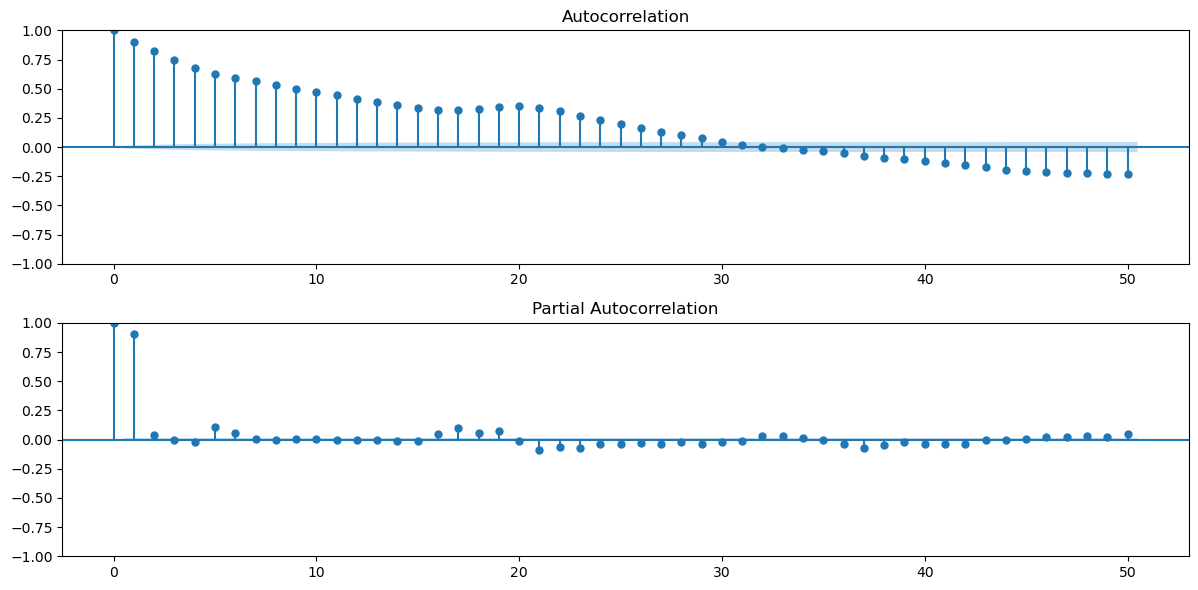

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(train, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()

Si mi interpretacion de los graficos es correcta, el valor de *q* deberia ser 28 y el de *p* deberia ser 1, considerando la region cercana al 0 como el intervalor de confianza. Sin embargo, no estoy convencido con estos valores, las razones son que el intervalo de confianza del primer grafico es pequeño, mientras que en el segundo no es visible. La otra razon es que tras multiples pruebas, nunguna combinacion de parametros dio un mejor resultado.

Asi que voy a probar el modelo previo pero con la otra variable de interes *Usage_kWh*.

## 7. Visualizacion de la serie de temporal del potencial

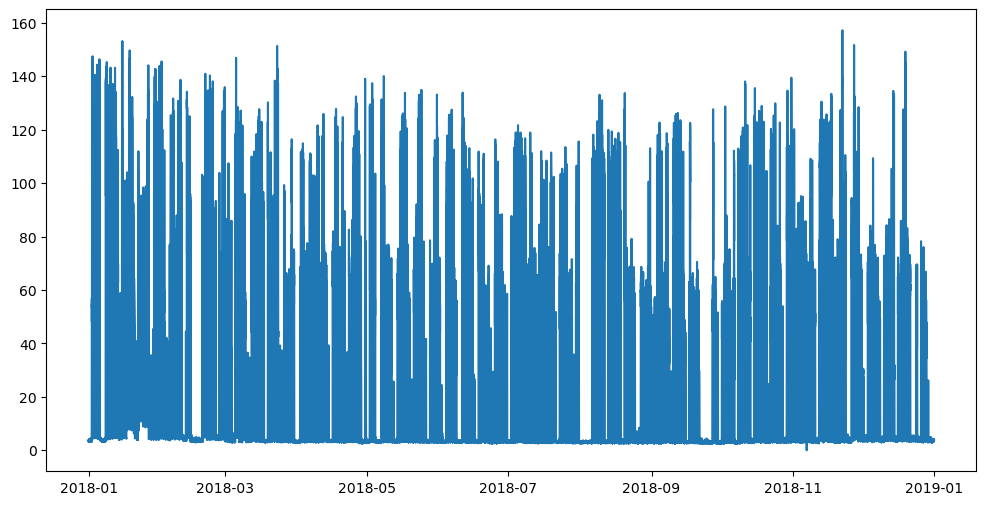

In [20]:
plt.figure(figsize= (12, 6))
plt.plot(df['Usage_kWh'], label = 'Huella de Carbono(tCO2)')
plt.show()

### 7.1 Serie diferenciada

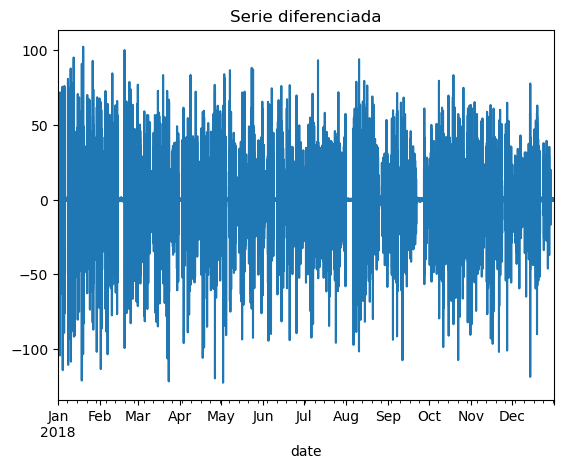

In [22]:
df['Usage_kWh_diff'] = df['Usage_kWh'].diff()
df['Usage_kWh_diff'].plot(title='Serie diferenciada')
plt.show()

### 7.2 Descomposicion estacional

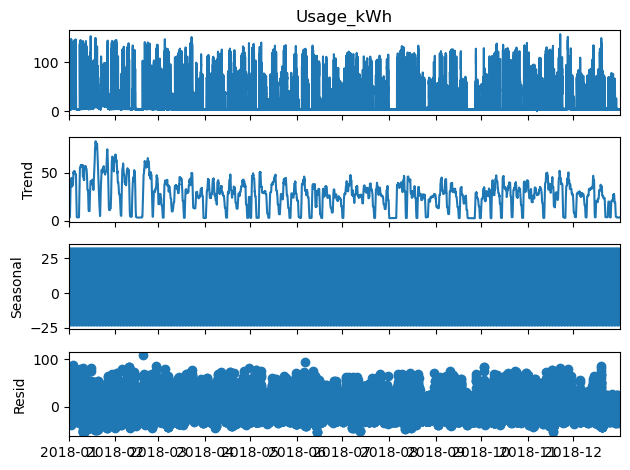

In [23]:
decomposition = seasonal_decompose(df['Usage_kWh'], model = 'additive', period = 96)
decomposition.plot()
plt.show()

## 8. Modelizacion Usage_kWh

### 8.1 Separar el dataset

In [24]:
train = df['Usage_kWh'][:int(0.8 * len(df))]
test = df['Usage_kWh'][int(0.8 * len(df)):]

### 8.2 Instanciar y entrenar el modelo

In [25]:
model = ARIMA(train, order=(5, 1, 2))  
model_fit = model.fit()

C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\matia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 8.3 Predicciones

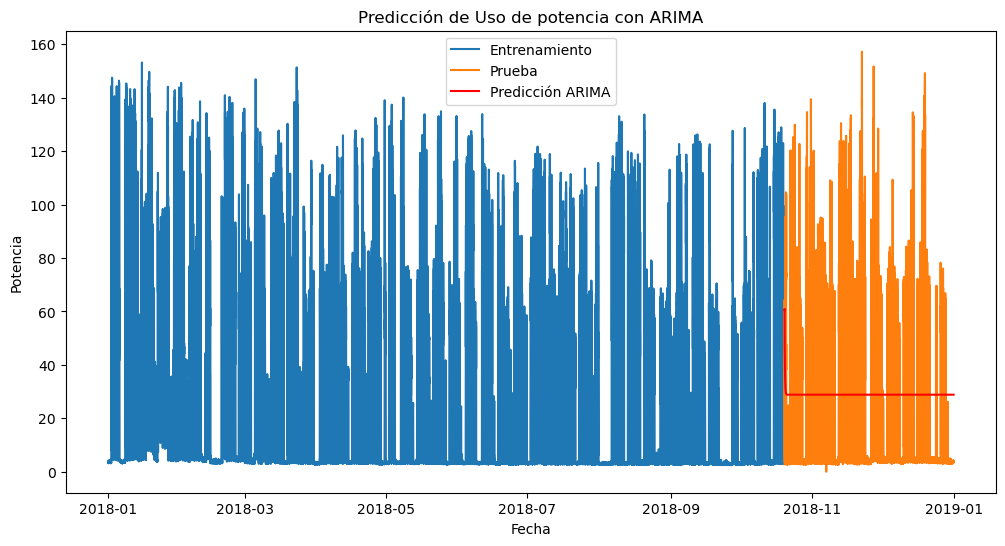

In [26]:
forecast_arima = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(test.index, forecast_arima, label='Predicción ARIMA', color='red')
plt.legend()
plt.title('Predicción de Uso de potencia con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Potencia')
plt.show()

In [29]:
forecast_arima

2018-10-20 00:00:00    60.574152
2018-10-20 00:15:00    60.910730
2018-10-20 00:30:00    54.642151
2018-10-20 00:45:00    53.126920
2018-10-20 01:00:00    51.357980
                         ...    
2018-12-31 22:45:00    28.829674
2018-12-31 23:00:00    28.829674
2018-12-31 23:15:00    28.829674
2018-12-31 23:30:00    28.829674
2018-12-31 23:45:00    28.829674
Freq: 15min, Name: predicted_mean, Length: 7008, dtype: float64

#### 8.3.1 MAE

In [27]:
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

print(f"MAE del modelo ARIMA: {mae_arima}")
print(f"RMSE del modelo ARIMA: {rmse_arima}")

MAE del modelo ARIMA: 28.07770651683059
RMSE del modelo ARIMA: 31.620284472465503
